In [1]:
import numpy as np 
import pandas as pd 
import sys
import os
from sklearn.model_selection import train_test_split
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt
import warnings
import itertools
from scipy import stats
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=10,20

# Add the grandparent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
from Utils import FE_helper as FE


c:\Users\yangs\.conda\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [127]:
# 2. Load the data
train_df_original = pd.read_csv('../Original_Data/train_2025.csv') 
train_df = pd.read_csv('../Original_Data/train_2025.csv') 
test_df = pd.read_csv('../Original_Data/test_2025.csv')

train_df = FE.add_features(train_df)
test_df = FE.add_features(test_df)

test_id = test_df['claim_number']
train_id = train_df['claim_number']
target = train_df['fraud']

ignore_var = ['claim_date.is_weekend', 'claim_date.near_holiday', 'fraud']
train_df = FE.drop_ignored_columns(train_df, ignore_var)
test_df = FE.drop_ignored_columns(test_df, ignore_var)

In [3]:
def filter_low_cardinality_columns(df, threshold=20, dropna=False):
    """
    Filters columns with unique value counts ≤ threshold.
    """
    low_card_cols = [col for col in df.columns if df[col].nunique(dropna=dropna) <= threshold]
    # print(f"Low-cardinality columns (≤ {threshold} unique values): {low_card_cols}")
    return low_card_cols

def generate_column_combinations(columns, sizes=[2, 3]):
    """
    Generates all combinations of the given columns at specified sizes.
    """
    combos = []
    for k in sizes:
        combos.extend(itertools.combinations(columns, k))
    print(f"Generated {len(combos)} combinations (sizes {sizes}).")
    return combos


def add_presence_features(df, combos):
    """
    For each column combination, adds a binary feature:
    1 if the row's combination appears elsewhere in the dataset, 0 otherwise.
    Shows a progress indicator.
    """
    df_out = df.copy()
    total = len(combos)

    for i, combo in enumerate(combos, 1):
        combo_name = "__".join(combo) + "_present"
        
        # Progress indicator
        progress_msg = f"\rProcessing {i} / {total} combos ({100 * i / total:.2f}%)"
        sys.stdout.write(progress_msg)
        sys.stdout.flush()
        
        # Create a tuple column for matching
        combo_tuples = df[list(combo)].apply(tuple, axis=1)
        # Count how many times each tuple appears
        counts = combo_tuples.map(combo_tuples.value_counts())
        # Presence = appears more than once
        df_out[combo_name] = (counts > 1).astype(int)
    
    # Final newline to clean up progress line
    sys.stdout.write("\nDone!\n")

    return df_out

def generate_all_nonempty_subsets(features):
    """
    Generates all nonempty subsets (combinations) of the given feature list.
    
    Parameters:
    - features (list): List of feature names.
    
    Returns:
    - list of tuples: All nonempty subsets.
    """
    all_subsets = []
    for k in range(1, len(features) + 1):
        combos = list(itertools.combinations(features, k))
        all_subsets.extend(combos)
    print(f"Generated {len(all_subsets)} total nonempty subsets.")
    return all_subsets

def compute_fraud_rate_differences(df, target_col='fraud', suffix='_present', variance_threshold=None):
    """
    Computes the difference in fraud rates between rows with feature == 1 and feature == 0
    for all columns ending with the given suffix.
    
    Parameters:
    - df (pd.DataFrame): Input DataFrame
    - target_col (str): Name of the target binary column (e.g., 'fraud')
    - suffix (str): Suffix to identify newly added features
    - filter_zero_variance (bool): Whether to exclude columns with zero variance
    
    Returns:
    - pd.DataFrame: Feature name, fraud rate at 0, fraud rate at 1, and the difference
    """
    results = []

    # Select columns with the specified suffix
    feature_cols = [col for col in df.columns if col.endswith(suffix)]

    if variance_threshold is not None:
        variances = df[feature_cols].var()
        feature_cols = [col for col in feature_cols if variances[col] > variance_threshold]
        print(f"Kept {len(feature_cols)} higher-variance features.")

    for col in feature_cols:
        grouped = df.groupby(col)[target_col].mean()
        rate_0 = grouped.get(0, None)
        rate_1 = grouped.get(1, None)
        if rate_0 is not None and rate_1 is not None:
            diff = rate_1 - rate_0
            var = df[col].var()
            results.append({
                'feature': col,
                'fraud_rate_at_0': rate_0,
                'fraud_rate_at_1': rate_1,
                'difference': diff,
                'variance': var
            })

    results_df = pd.DataFrame(results).sort_values(by='difference', key=abs, ascending=False)
    return results_df

In [ ]:
additional_drops = ['vehicle_price_categories', 'zero_payout', 'log_pop_bin', 'age_group', 'past_num_of_claims', 'age_of_vehicle', 'claim_date.weekofyear', 'claim_date.day', 'claim_date.quarter', 'zipcode_type']

low_performing_col = train_df[filter_low_cardinality_columns(train_df, threshold=60)].drop(columns = additional_drops).columns.tolist()

# Step 2: Generate all 2- and 3-column combinations
combos = generate_all_nonempty_subsets(low_performing_col)

# Step 3: Add binary presence features
df_with_features = add_presence_features(train_df, combos)

print("New dataset shape:", df_with_features.shape)

In [ ]:
df_with_features['fraud'] = target
fraud_diffs = compute_fraud_rate_differences(df_with_features, target_col='fraud', variance_threshold=0.1)
temp_1 = fraud_diffs[np.abs(fraud_diffs['difference']) > 0.03]

temp_1['info'] = (temp_1['variance']/0.25)*np.abs(temp_1['difference'])
temp_1 = temp_1.sort_values(by='info', ascending=False)
temp_1.to_csv('logs/subset_info_3.csv', index = False)

Kept 11877 higher-variance features.


In [4]:
low_card_col = filter_low_cardinality_columns(train_df, threshold=120)

custom_cols = ['claim_date.weekofyear', 'claim_date.quarter', 'log_pop_bin', 'vehicle_price_categories', 'zero_payout']
low_card_col = [col for col in low_card_col if col not in custom_cols]


# Step 2: Generate all 2- and 3-column combinations
combos_2345 = generate_column_combinations(low_card_col, [2, 3, 4, 5])

# Step 3: Add binary presence features
df_with_features_2345 = add_presence_features(train_df, combos_2345)

print("New dataset shape:", df_with_features_2345.shape)

Generated 44528 combinations (sizes [2, 3, 4, 5]).
Processing 1 / 44528 combos (0.00%)

Processing 44528 / 44528 combos (100.00%)
Done!
New dataset shape: (18000, 44571)


In [5]:
df_with_features_2345['fraud'] = target
fraud_diffs_2345 = compute_fraud_rate_differences(df_with_features_2345, target_col='fraud', variance_threshold=0.1)
temp_2 = fraud_diffs_2345[np.abs(fraud_diffs_2345['difference']) > 0.03]

temp_2['info'] = (temp_2['variance']/0.25)*np.abs(temp_2['difference'])
temp_2 = temp_2.sort_values(by='info', ascending=False)
temp_2.to_csv('logs/subset_info_2.csv', index = False)

Kept 16238 higher-variance features.


# Start Running Here

In [2]:
import numpy as np 
import pandas as pd 
import sys
import os
from sklearn.model_selection import train_test_split
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
import warnings
from datetime import datetime
import itertools
from scipy import stats
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=10,20

# Add the grandparent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
from Utils import FE_helper as FE


c:\Users\yangs\.conda\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 2. Load the data
train_df = pd.read_csv('../Original_Data/train_2025.csv') 
test_df = pd.read_csv('../Original_Data/test_2025.csv')

train_df = FE.add_features(train_df)
test_df = FE.add_features(test_df)

test_id = test_df['claim_number']
train_id = train_df['claim_number']
target = train_df['fraud']

ignore_var = ['claim_date.is_weekend', 'claim_date.near_holiday', 'fraud']
train_df = FE.drop_ignored_columns(train_df, ignore_var)
test_df = FE.drop_ignored_columns(test_df, ignore_var)

In [4]:
presence_info_df_3 = pd.read_csv('logs/subset_info_3.csv')
presence_info_df_3 = presence_info_df_3[(np.abs(presence_info_df_3['difference']) > 0.05) & (presence_info_df_3['info'] > 0.03)]

# presence_info_df_2 = pd.read_csv('logs/subset_info_2.csv')
# presence_info_df_2 = presence_info_df_2[(np.abs(presence_info_df_2['difference']) > 0.065) | (presence_info_df_2['info'] > 0.045)]

In [5]:
# presence_info_df = pd.concat([presence_info_df_2, presence_info_df_3])
presence_info_df = presence_info_df_3
presence_info_df.shape

(40, 6)

In [135]:
def add_presence_columns(train_df, presence_info_df, verbose = False):
    """
    For each combo in presence_info_df, create a presence feature on train_df.
    
    Parameters:
    - train_df (pd.DataFrame): The training dataset.
    - presence_info_df (pd.DataFrame): DataFrame containing 'feature' column
      with names like 'feature1__feature2__feature3_present'.
    
    Returns:
    - pd.DataFrame: train_df with new presence columns added.
    """
    df_out = train_df.copy()
    
    for combo_str in presence_info_df['feature']:
        # Extract base combo name (strip trailing '_present')
        if combo_str.endswith('_present'):
            combo_base = combo_str[:-8]
        else:
            combo_base = combo_str
        
        # Split by '__' to get the individual features
        combo_features = combo_base.split('__')
        new_col_name = combo_base + '_present'  # keep consistent
        if verbose:
            print(f"Processing combo: {combo_features}")
        
        # Build tuple of feature values per row
        combo_tuples = train_df[combo_features].apply(tuple, axis=1)
        
        # Count how many times each tuple appears
        counts = combo_tuples.map(combo_tuples.value_counts())
        
        # Presence = appears more than once in the dataset
        df_out[new_col_name] = (counts > 1).astype(int)
    
    return df_out


def fit_presence_pca(train_df, present_cols, n_components=None, scale=True):
    """
    Fits PCA on presence feature columns in the training set.
    
    Parameters:
    - train_df (pd.DataFrame): Training dataset.
    - present_cols (list): List of column names for presence features.
    - n_components (int or None): Number of PCA components. If None, keep all.
    - scale (bool): Whether to standardize columns before PCA.
    
    Returns:
    - pca (PCA object): Fitted PCA object.
    - X_train_pca (np.ndarray): Transformed training set (PCA scores).
    - scaler (StandardScaler object or None): Fitted scaler if used, else None.
    """
    X = train_df[present_cols].values

    # Optionally scale features
    scaler = None
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Fit PCA
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X)

    print(f"PCA fitted. Explained variance (first 10 components): {pca.explained_variance_ratio_[:10]}")
    return pca, X_train_pca, scaler


In [136]:
updated_train_df = add_presence_columns(train_df, presence_info_df)
updated_test_df = add_presence_columns(test_df, presence_info_df)

present_cols = [col for col in updated_train_df.columns if col.endswith('_present')]

In [137]:
updated_train_df = add_presence_columns(train_df, presence_info_df)
updated_test_df = add_presence_columns(test_df, presence_info_df)

present_cols = [col for col in updated_train_df.columns if col.endswith('_present')]
non_present_cols = [col for col in updated_train_df.columns if not col.endswith('_present')]
# print(updated_train_df[non_present_cols].info())


high_dim_cat_cols_to_drop = ['claim_date.day', 'claim_date.dayofweek', 'claim_date.weekofyear', 'claim_date.month', 'zero_payout']
updated_train_df.drop(columns = high_dim_cat_cols_to_drop, inplace=True)
updated_test_df.drop(columns = high_dim_cat_cols_to_drop, inplace=True)

In [138]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def fit_regular_transformer(train_df, presence_suffix='_present'):
    # Identify regular columns
    regular_cols = [col for col in train_df.columns if not col.endswith(presence_suffix)]
    
    # Split regular into categorical and numerical
    categorical_cols = train_df[regular_cols].select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = train_df[regular_cols].select_dtypes(include=['number']).columns.tolist()
    if 'claim_number' in numerical_cols:
        numerical_cols.remove('claim_number')
    
    # Initialize transformers
    onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    scaler = StandardScaler()
    
    # Fit transformers
    onehot.fit(train_df[categorical_cols])
    scaler.fit(train_df[numerical_cols])
    
    # print(f"Fitted on {len(categorical_cols)} categorical and {len(numerical_cols)} numerical columns.")
    
    return onehot, scaler, categorical_cols, numerical_cols

def transform_regular_set(df, onehot, scaler, categorical_cols, numerical_cols):
    # Transform categorical
    cat_transformed = onehot.transform(df[categorical_cols])
    cat_df = pd.DataFrame(cat_transformed, columns=onehot.get_feature_names_out(categorical_cols), index=df.index)
    
    # Transform numerical
    num_transformed = scaler.transform(df[numerical_cols])
    num_df = pd.DataFrame(num_transformed, columns=numerical_cols, index=df.index)
    
    # Combine transformed parts
    transformed_df = pd.concat([num_df, cat_df], axis=1)
    
    # print(f"Transformed set shape: {transformed_df.shape}")
    return transformed_df


In [139]:
# Step 1: Fit on training data
onehot, scaler, cat_cols, num_cols = fit_regular_transformer(updated_train_df)

# Step 2: Transform training set itself
X_train_regular = transform_regular_set(updated_train_df, onehot, scaler, cat_cols, num_cols)

# Step 3: Transform test set (call the same function on test_df)
X_test_regular = transform_regular_set(test_df, onehot, scaler, cat_cols, num_cols)

# present_cols = []
# Combine for train
updated_train_final = pd.concat([X_train_regular, updated_train_df[present_cols]], axis=1)

# Combine for test
updated_test_final = pd.concat([X_test_regular, updated_test_df[present_cols]], axis=1)

In [140]:
def objective(trial, full_train_df, target, kfoldcv=5, drop=[]):
    # Define hyperparameter space
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': True,
        'boosting': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 50, 90),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.3, 0.6),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.3, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 5, 25),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-3, 15.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),
        'verbose': -1,
        'seed':69
    }

    skf = StratifiedKFold(n_splits=kfoldcv, shuffle=True, random_state=42)
    best_thresholds = []
    f1_scores = []

    for train_idx, val_idx in skf.split(full_train_df, target):
        X_train = full_train_df.iloc[train_idx].drop(columns=drop, errors='ignore')
        X_val = full_train_df.iloc[val_idx].drop(columns=drop, errors='ignore')
        y_train = target.iloc[train_idx]
        y_val = target.iloc[val_idx]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

        model = lgb.train(
                params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=[lgb_val],
                callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
            )

        # Predict + threshold tuning
        probs = model.predict(X_val, num_iteration=model.best_iteration)
        thresholds = np.linspace(0.1, 0.9, 50)
        f1s = [f1_score(y_val, probs > t) for t in thresholds]

        best_f1 = max(f1s)
        best_threshold = thresholds[np.argmax(f1s)]

        f1_scores.append(best_f1)
        best_thresholds.append(best_threshold)

    mean_f1 = np.mean(f1_scores)
    mean_threshold = np.mean(best_thresholds)

    trial.set_user_attr('mean_threshold', mean_threshold)
    trial.set_user_attr('f1_per_fold', f1_scores)

    return mean_f1



In [ ]:
# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, updated_train_final, target, kfoldcv= 5),
                n_trials=500)

best_f1 = study.best_value

[I 2025-05-06 11:07:04,664] A new study created in memory with name: no-name-2d5d1cb4-55e3-4790-a2c4-037473740869
[I 2025-05-06 11:07:08,953] Trial 0 finished with value: 0.3648440489721164 and parameters: {'num_leaves': 66, 'feature_fraction': 0.5095743285404892, 'bagging_fraction': 0.6564571121753443, 'bagging_freq': 7, 'learning_rate': 0.07172420550564879, 'lambda_l1': 0.004752228374972006, 'lambda_l2': 0.0018300349542978926}. Best is trial 0 with value: 0.3648440489721164.
[I 2025-05-06 11:07:13,333] Trial 1 finished with value: 0.3629600125859006 and parameters: {'num_leaves': 70, 'feature_fraction': 0.41087933872601556, 'bagging_fraction': 0.735892506186001, 'bagging_freq': 15, 'learning_rate': 0.07730806444561315, 'lambda_l1': 0.0015156033348963365, 'lambda_l2': 7.400324051600011}. Best is trial 0 with value: 0.3648440489721164.
[I 2025-05-06 11:07:19,201] Trial 2 finished with value: 0.36769935282971783 and parameters: {'num_leaves': 61, 'feature_fraction': 0.32394683764236326,

In [60]:
# Paths
import json
output_dir = '../Data/processed/lgb_36578'
train_csv_path = os.path.join(output_dir, 'train_2025.csv')
test_csv_path = os.path.join(output_dir, 'test_2025.csv')
param_json_path = 'param_lgb_36578.json'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Save DataFrames
train_df.to_csv(train_csv_path, index=False)
print(f"Saved train DataFrame to {train_csv_path}")

test_df.to_csv(test_csv_path, index=False)
print(f"Saved test DataFrame to {test_csv_path}")

# Save best_params as JSON
best_threshold = study.best_trial.user_attrs['mean_threshold']
best_params = study.best_params
best_params.update({'mean_threshold': float(best_threshold)})
with open(param_json_path, 'w') as f:
    json.dump(best_params, f, indent=4)
print(f"Saved best parameters to {param_json_path}")

Saved train DataFrame to ../Data/processed/lgb_36578\train_2025.csv
Saved test DataFrame to ../Data/processed/lgb_36578\test_2025.csv
Saved best parameters to param_lgb_36578.json


In [76]:
# Split train into final train and validation sets
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    updated_train_final, target, test_size=0.2, stratify=target, random_state=42
)

# Create LightGBM datasets
lgb_train_final = lgb.Dataset(X_train_final, y_train_final)
lgb_val_final = lgb.Dataset(X_val_final, y_val_final, reference=lgb_train_final)

# Ensure best_params includes all needed keys
best_params.update({
    'objective': 'binary',
    'metric': ['auc', 'f1'],
    'is_unbalance': True,
    'boosting': 'gbdt',
    'verbose': -1,
    'seed': 42
})

# Train with early stopping
final_model = lgb.train(
    best_params,
    lgb_train_final,
    num_boost_round=5000,
    valid_sets=[lgb_val_final],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)  # Optional: adjust or silence logging
    ]
)

# Predict on test set
probs_test = final_model.predict(updated_test_final, num_iteration=final_model.best_iteration)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.694981
[200]	valid_0's auc: 0.695765
Early stopping, best iteration is:
[135]	valid_0's auc: 0.697809


In [ ]:
timestamp = datetime.now().strftime('%m%d_%H%M')

final_preds = (probs_test > best_threshold).astype(int)

submission = pd.DataFrame({
    'claim_number': test_id,
    'fraud': final_preds
})

submission.to_csv(f'../Submit/submission.csv', index=False)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

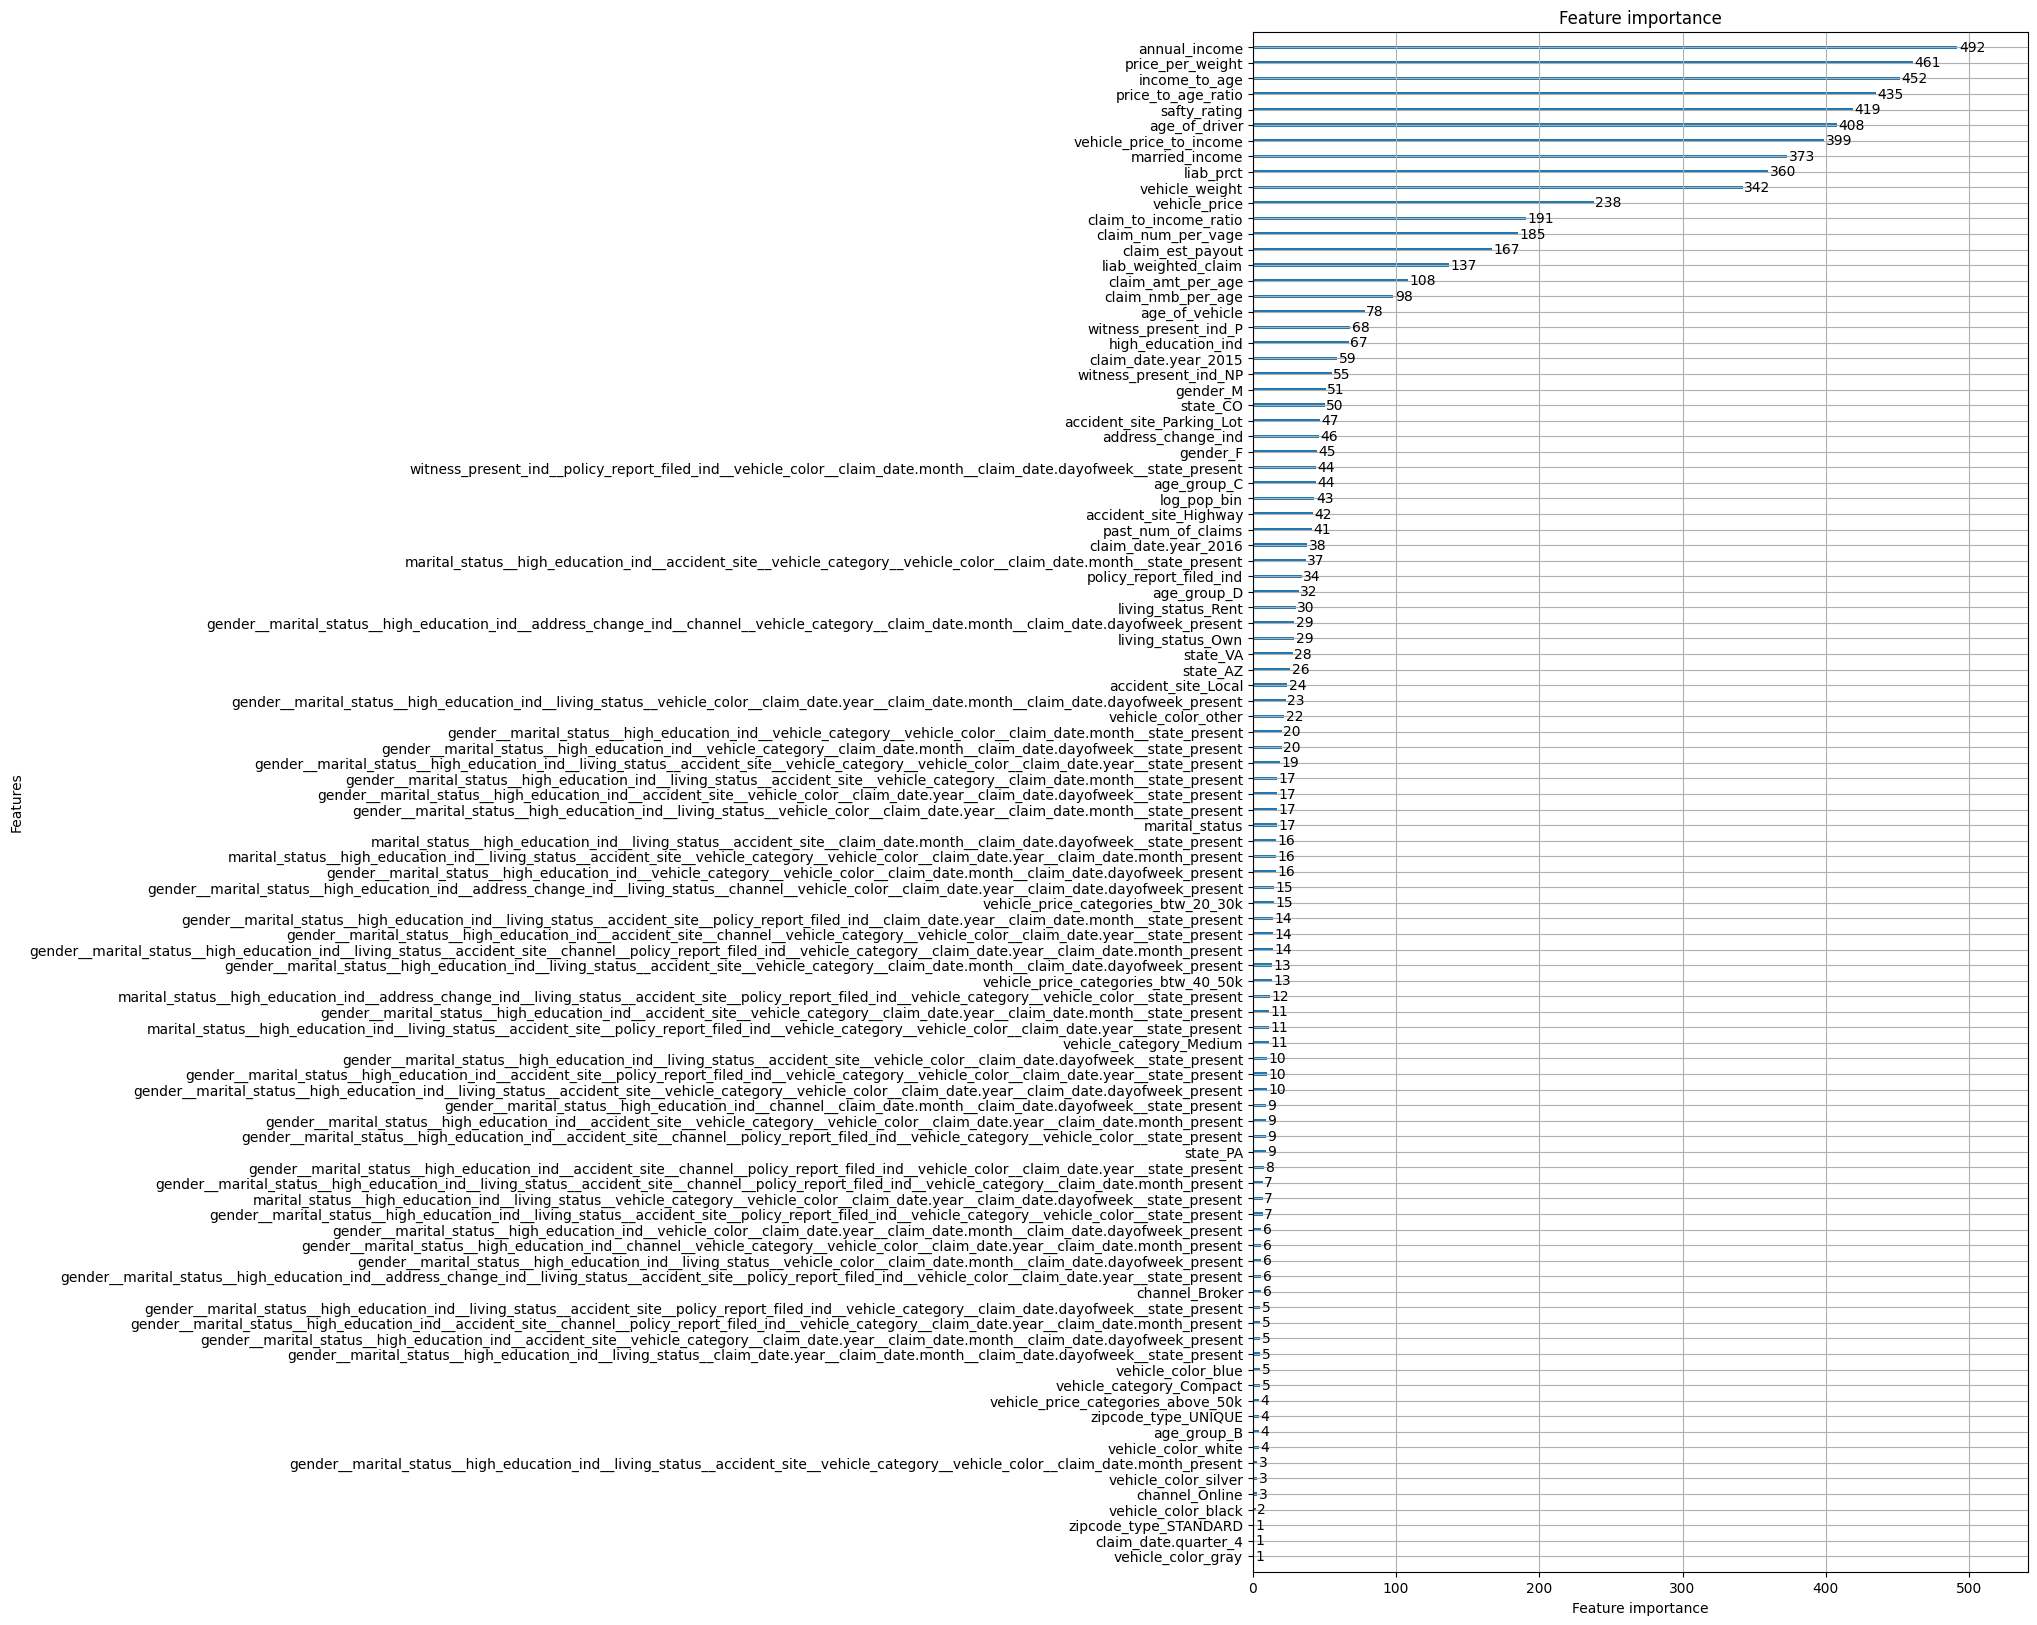

In [119]:
lgb.plot_importance(final_model)

In [ ]:
from Utils import helper_fn as helper

helper.plot_fraud_rate_by_category(train_df_original, 'vehicle_color')

KeyError: 'Column not found: fraud'